In [5]:
import numpy
from matplotlib import pyplot
import py_monte_carlo
import scipy.sparse
import scipy.linalg

## Including Transverse field

In [6]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0), ((4, 0), -1.0)]
transverse = 1.0
nvars = 5

graph = py_monte_carlo.Lattice(edges)
graph.set_transverse_field(transverse)

In [7]:
betas = [0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 40.0]

In [21]:
q_transverse_data = numpy.zeros(len(betas))
q_energies_data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 16, exponent=2)
    q_transverse_data[i] = numpy.mean(results, axis=0)
    q_energies_data[i] = numpy.mean(energies)

In [22]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = numpy.zeros((2**nvars,2**nvars))
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        for j in range(i+1, 2**nvars):
            b_state = [(j >> k) & 1 for k in range(nvars)]
            diffstate = [a^b for a,b in zip(state, b_state)]
            if sum(diffstate) != 1:
                continue
            for vark,s in enumerate(diffstate):
                if not s:
                    continue
                ham[i, j] = ham[i,j] + transverse
                ham[j, i] = ham[j,i] + transverse

    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = numpy.diag(spin_diag)
    return ham, spin_op

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

In [23]:
ed_transverse_data = []
ed_transverse_energies = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    ed_transverse_energies.append(numpy.trace(ham @ expm) / numpy.trace(expm))

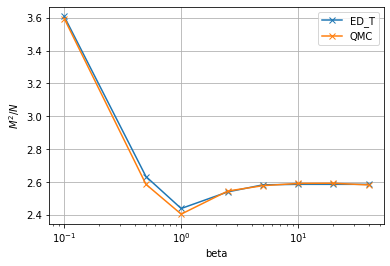

In [24]:
pyplot.plot(betas, ed_transverse_data, 'x-', label="ED_T")
pyplot.plot(betas, q_transverse_data, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.savefig("compare.png")
pyplot.show()

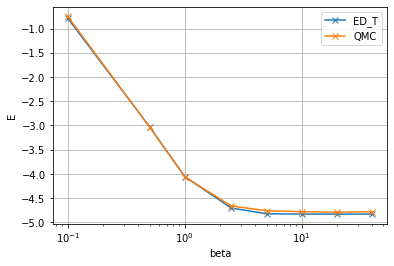

In [25]:
pyplot.plot(betas, ed_transverse_energies, 'x-', label="ED_T")
pyplot.plot(betas, q_energies_data, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.savefig("energies.png")
pyplot.show()

## Lattice stuff

Lets make a small 4-8 lattice, start with a single unit cell

In [26]:
edges = [
    ((0, 1), -1.0),
    ((1, 2), 1.0),
    ((2, 3), 1.0),
    ((3, 0), 1.0)
]
nvars = 4
transverse = 1.0

graph = py_monte_carlo.Lattice(edges)
graph.set_transverse_field(transverse)

In [27]:
betas = [0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 40.0]

In [28]:
lattice_qmc_data = numpy.zeros(len(betas))
lattice_qmc_energy = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    lattice_qmc_data[i] = numpy.mean(results, axis=0)
    lattice_qmc_energy[i] = numpy.mean(energies)

In [29]:
lattice_ed_data = []
lattice_ed_energy = []

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    lattice_ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    lattice_ed_energy.append(numpy.trace(ham @ expm) / numpy.trace(expm))

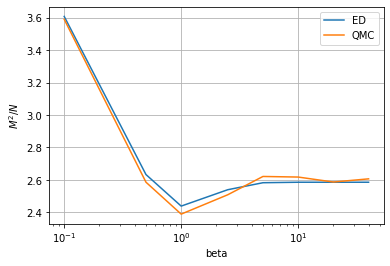

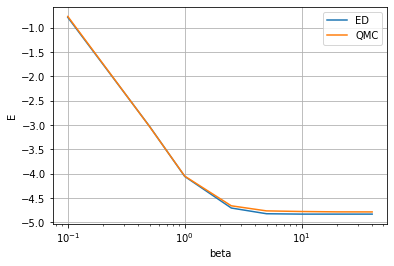

In [30]:
pyplot.plot(betas, lattice_ed_data, label='ED')
pyplot.plot(betas, lattice_qmc_data, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(betas, lattice_ed_energy, label='ED')
pyplot.plot(betas, lattice_qmc_energy, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

In [31]:
hs = 10**numpy.linspace(-1, 1, 10)
beta = 1.0

In [32]:
lattice_qmc_data_hs = numpy.zeros(len(hs))
lattice_qmc_energy_hs = numpy.zeros(len(hs))
graph = py_monte_carlo.Lattice(edges)

for i, h in enumerate(hs):
    graph.set_transverse_field(h)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    lattice_qmc_data_hs[i] = numpy.mean(results, axis=0)
    lattice_qmc_energy_hs[i] = numpy.mean(energies)

In [33]:
lattice_ed_data_hs = []
lattice_ed_energy_hs = []

for h in hs:
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    lattice_ed_data_hs.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    lattice_ed_energy_hs.append(numpy.trace(ham @ expm) / numpy.trace(expm))

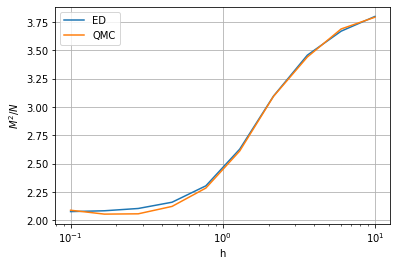

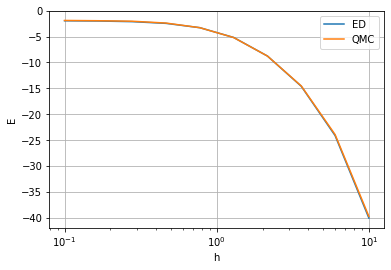

In [34]:
pyplot.plot(hs, lattice_ed_data_hs, label='ED')
pyplot.plot(hs, lattice_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, lattice_ed_energy_hs, label='ED')
pyplot.plot(hs, lattice_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()

### Two unit cell lattice

In [35]:
edges = [
    ((0, 1), -1.0),
    ((1, 2), 1.0),
    ((2, 3), 1.0),
    ((3, 0), 1.0),
    
    ((1, 7), 1.0),
    
    ((4, 5), -1.0),
    ((5, 6), 1.0),
    ((6, 7), 1.0),
    ((7, 4), 1.0)
]
nvars = 8
transverse = 1.0

graph = py_monte_carlo.Lattice(edges)
graph.set_transverse_field(transverse)

In [36]:
large_lattice_qmc_data = numpy.zeros(len(betas))
large_lattice_qmc_energy = numpy.zeros(len(betas))

for i, beta in enumerate(betas):
    print(beta)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 100000, 8, exponent=2)
    large_lattice_qmc_data[i] = numpy.mean(results, axis=0)
    large_lattice_qmc_energy[i] = numpy.mean(energies)

0.1
0.5
1.0
2.5
5.0
10.0
20.0
40.0


In [37]:
large_lattice_ed_data = []
large_lattice_ed_energy = []

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    large_lattice_ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    large_lattice_ed_energy.append(numpy.trace(ham @ expm) / numpy.trace(expm))

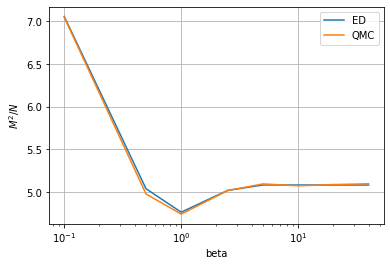

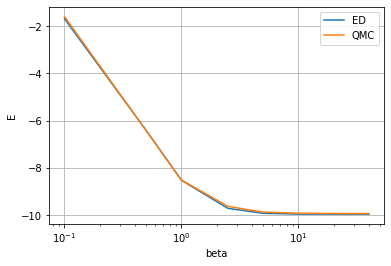

In [38]:
pyplot.plot(betas, large_lattice_ed_data, label='ED')
pyplot.plot(betas, large_lattice_qmc_data, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(betas, large_lattice_ed_energy, label='ED')
pyplot.plot(betas, large_lattice_qmc_energy, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

In [39]:
hs = 10**numpy.linspace(-1, 1, 10)
beta = 1.0

In [40]:
large_lattice_qmc_data_hs = numpy.zeros(len(hs))
large_lattice_qmc_energy_hs = numpy.zeros(len(hs))
graph = py_monte_carlo.Lattice(edges)

for i, h in enumerate(hs):
    graph.set_transverse_field(h)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    large_lattice_qmc_data_hs[i] = numpy.mean(results, axis=0)
    large_lattice_qmc_energy_hs[i] = numpy.mean(energies)

In [41]:
large_lattice_ed_data_hs = []
large_lattice_ed_energy_hs = []

for h in hs:
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    large_lattice_ed_data_hs.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    large_lattice_ed_energy_hs.append(numpy.trace(ham @ expm) / numpy.trace(expm))

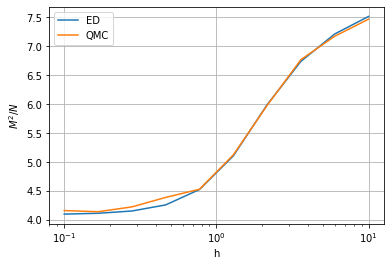

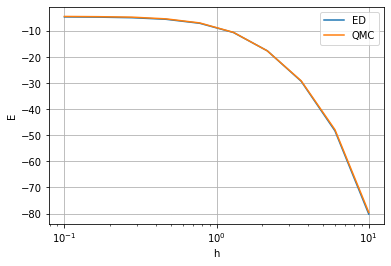

In [42]:
pyplot.plot(hs, large_lattice_ed_data_hs, label='ED')
pyplot.plot(hs, large_lattice_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, large_lattice_ed_energy_hs, label='ED')
pyplot.plot(hs, large_lattice_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()

## Superclique

In [43]:
nvars = 8

edges = [((i,j), 1.0) for i in range(nvars) for j in range(i)]
transverse = 1.0

graph = py_monte_carlo.Lattice(edges)
graph.set_transverse_field(transverse)

In [44]:
clique_qmc_data = numpy.zeros(len(betas))
clique_qmc_energy = numpy.zeros(len(betas))

for i, beta in enumerate(betas):
    print(beta)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 100000, 8, exponent=2)
    clique_qmc_data[i] = numpy.mean(results, axis=0)
    clique_qmc_energy[i] = numpy.mean(energies)

0.1
0.5
1.0
2.5
5.0
10.0
20.0
40.0


In [45]:
clique_ed_data = []
clique_ed_energy = []

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    clique_ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    clique_ed_energy.append(numpy.trace(ham @ expm) / numpy.trace(expm))

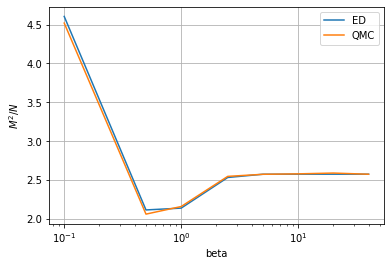

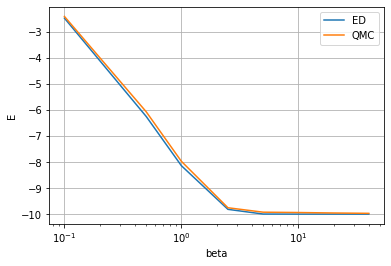

In [46]:
pyplot.plot(betas, clique_ed_data, label='ED')
pyplot.plot(betas, clique_qmc_data, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(betas, clique_ed_energy, label='ED')
pyplot.plot(betas, clique_qmc_energy, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

In [47]:
hs = 10**numpy.linspace(-1, 1, 10)
beta = 1.0

In [48]:
clique_qmc_data_hs = numpy.zeros(len(hs))
clique_qmc_energy_hs = numpy.zeros(len(hs))
graph = py_monte_carlo.Lattice(edges)

for i, h in enumerate(hs):
    graph.set_transverse_field(h)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    clique_qmc_data_hs[i] = numpy.mean(results, axis=0)
    clique_qmc_energy_hs[i] = numpy.mean(energies)

In [49]:
clique_ed_data_hs = []
clique_ed_energy_hs = []

for h in hs:
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    clique_ed_data_hs.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    clique_ed_energy_hs.append(numpy.trace(ham @ expm) / numpy.trace(expm))

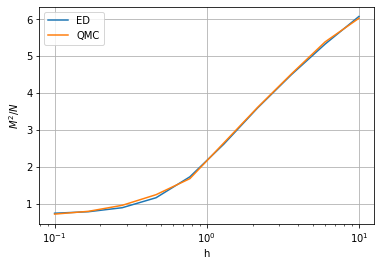

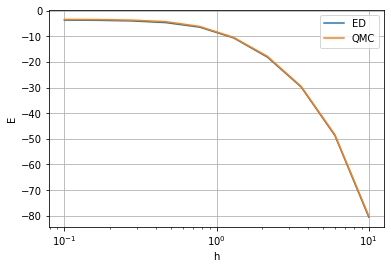

In [50]:
pyplot.plot(hs, clique_ed_data_hs, label='ED')
pyplot.plot(hs, clique_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, clique_ed_energy_hs, label='ED')
pyplot.plot(hs, clique_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()

## Heatbath

In [ ]:
large_lattice_qmc_data_heatbath = numpy.zeros(len(betas))
large_lattice_qmc_energy_heatbath = numpy.zeros(len(betas))

for i, beta in enumerate(betas):
    print(beta)
    results = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2, use_heatbath_diagonal_update=True)
    results, energies = zip(*results)
    large_lattice_qmc_data_heatbath[i] = numpy.mean(results, axis=0)
    large_lattice_qmc_energy_heatbath[i] = numpy.mean(energies)

In [ ]:
pyplot.plot(betas, large_lattice_ed_data, label='ED')
pyplot.plot(betas, large_lattice_qmc_data, label='QMC')
pyplot.plot(betas, large_lattice_qmc_data_heatbath, label='HEATBATH')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(betas, large_lattice_ed_energy, label='ED')
pyplot.plot(betas, large_lattice_qmc_energy, label='QMC')
pyplot.plot(betas, large_lattice_qmc_energy_heatbath, label='HEATBATH')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

In [ ]:
beta = 1.0

large_lattice_qmc_data_heatbath_hs = numpy.zeros(len(hs))
large_lattice_qmc_energy_heatbath_hs = numpy.zeros(len(hs))

for i, h in enumerate(hs):
    print(h)
    results = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2, use_heatbath_diagonal_update=True)
    results, energies = zip(*results)
    large_lattice_qmc_data_heatbath_hs[i] = numpy.mean(results, axis=0)
    large_lattice_qmc_energy_heatbath_hs[i] = numpy.mean(energies)

In [ ]:
pyplot.plot(hs, large_lattice_ed_data_hs, label='ED')
pyplot.plot(hs, large_lattice_qmc_data_heatbath_hs, label='HEATBATH')
pyplot.plot(hs, large_lattice_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, large_lattice_ed_energy_hs, label='ED')
pyplot.plot(hs, large_lattice_qmc_energy_heatbath_hs, label='HEATBATH')
pyplot.plot(hs, large_lattice_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()

### Double checking that bump near $\beta = 2$

I thought that the bump in the $\frac{M^2}{N}$ graph for the loop of ising spins was interesting, decided to investigate further using ED methods.

In [ ]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0), ((4, 0), -1.0)]
transverse = 1.0
nvars = 5
betas = 10**numpy.linspace(-2,2,50)

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

In [ ]:
ed_transverse_data = []
ed_transverse_energies = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm) / nvars)

In [ ]:
pyplot.plot(betas, ed_transverse_data)
pyplot.xscale('log')
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

In [ ]:
dat = []

for nvars in range(3, 10):
    edges = [((v, v+1), -1.0) for v in range(nvars-1)] + [((nvars-1, 0), -1.0)]
    ham, spin_op = make_ham_and_spin(nvars, edges, transverse)
    tmp_ed_transverse_data = []
    for beta in betas:
        expm = scipy.linalg.expm(-beta*ham)
        tmp_ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm) / nvars)
    dat.append(tmp_ed_transverse_data)
    pyplot.plot(betas, tmp_ed_transverse_data, label="{}".format(nvars))

pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.savefig("average_m_bump.png")
pyplot.show()

### Eigenstates of n=3

In [ ]:
nvars = 3
edges = [((v, v+1), -1.0) for v in range(nvars-1)] + [((nvars-1, 0), -1.0)]
ham, spin_op = make_ham_and_spin(nvars, edges, transverse)
ham

In [ ]:
ls, vs = numpy.linalg.eig(ham)
spin_expt = numpy.diag(vs.T @ (spin_op @ vs))/3
spin_expt

In [ ]:
pyplot.plot(ls, spin_expt, 'x')
pyplot.xlabel("E")
pyplot.ylabel("$M^2/N$")
pyplot.grid()
pyplot.show()

In [ ]:
spin_heated_values = []
for beta in betas:
    weights = numpy.exp(-beta*ls)
    z = numpy.sum(weights)
    spin_heated = numpy.sum(weights * spin_expt) / z
    spin_heated_values.append(spin_heated)
pyplot.plot(betas, spin_heated_values, label="Eig")
pyplot.plot(betas, dat[0], label="ED")
pyplot.xscale('log')
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.legend()
pyplot.show()

Ok, guess it's real, not sure why these don't agree for small beta, the methods should be doing the same thing (exponentiating the eigenvalues and summing them).

### Varying H

In [ ]:
betas = 10**numpy.linspace(-2,2,50)
transverse = 1.0
nvars = 3
dat = []
edges = [((v, v+1), -1.0) for v in range(nvars-1)] + [((nvars-1, 0), -1.0)]
hs = numpy.linspace(-5,5,50)
for h in hs:    
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    tmp_ed_transverse_data = []
    for beta in betas:
        expm = scipy.linalg.expm(-beta*ham)
        tmp_ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm) / nvars)
    dat.append(tmp_ed_transverse_data)
    pyplot.plot(betas, tmp_ed_transverse_data)

pyplot.xscale('log')
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

In [ ]:
bump_size = [numpy.max(d) - d[-1] for d in dat]
pyplot.plot(hs, bump_size)
pyplot.grid()
pyplot.xlabel("h/J")
pyplot.ylabel("$\Delta(M^2/N)$")
pyplot.show()

In [ ]:
bump_ratio = [numpy.max(d) / d[-1] for d in dat]
pyplot.plot(hs, bump_ratio)
pyplot.grid()
pyplot.xlabel("h/J")
pyplot.ylabel("Ratio")
pyplot.show()

In [ ]:
transverse = 1.0
nvars = 3
edges = [((v, v+1), -1.0) for v in range(nvars-1)] + [((nvars-1, 0), -1.0)]
hs = numpy.linspace(-5,5,50)

for nvars in range(3, 7):
    ratios = []
    for h in hs:    
        ham, spin_op = make_ham_and_spin(nvars, edges, h)
        tmp_ed_transverse_data = []
        for beta in betas:
            expm = scipy.linalg.expm(-beta*ham)
            tmp_ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm) / nvars)
        bump_ratio = numpy.max(tmp_ed_transverse_data) / tmp_ed_transverse_data[-1]
        ratios.append(bump_ratio)
    pyplot.plot(hs, ratios, label="{}".format(nvars))

pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("Ratio")
pyplot.show()